In [1]:
import pandas as pd
from konlpy.tag import Hannanum
import yfinance as yf
import datetime
import numpy as np
import warnings
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
warnings.filterwarnings('ignore')

In [2]:
def raw_data_merge (list):
    
    df = pd.DataFrame()

    for i in list:
        tmp = pd.read_excel(i)
        df = pd.concat([df, tmp])
    
    return df

In [3]:
def df_process (df):
    
    df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
    df = df.set_index('일자')

    df = df.sort_index(ascending=True) 

    df = df[['제목']].copy()

    start_date_str = str(df.index.unique()[0])[0:10]
    end_date_str = str(df.index.unique()[-1])[0:10]

    check = yf.download('^KS11', start_date_str, end_date_str, progress=False)
    check['signal'] = np.where((check['Close'] - check['Open'])> 0 , int(1), int(0))    

    for i in check.index:
        df.loc[(df.index == i), 'signal'] = check.loc[i, 'signal']

    df = df.dropna()

    return df

In [4]:
def clean_doc (doc):
    
    doc = re.sub(r'[^\wㄱ-ㅎ가-힣]', ' ', doc)
    doc = re.sub('  ', ' ', doc)
    doc = re.sub('  ', ' ', doc)

    return doc

In [5]:
file_list = os.listdir(".")
data_list = [x for x in file_list if x.endswith(".xlsx")]
data_list

['NewsResult_20220115-20220131.xlsx',
 'NewsResult_20211101-20211115.xlsx',
 'NewsResult_20211201-20211215.xlsx',
 'NewsResult_20211016-20211031.xlsx',
 'NewsResult_20220301-20220315.xlsx',
 'NewsResult_20211116-20211130.xlsx',
 'NewsResult_20220201-20220215.xlsx',
 'NewsResult_20220101-20220114.xlsx',
 'NewsResult_20211216-20211231.xlsx',
 'NewsResult_20220215-20220228.xlsx',
 'NewsResult_20220315-20220331.xlsx']

In [6]:
df = raw_data_merge(data_list[0:len(data_list)-3])
df2 = raw_data_merge(data_list[len(data_list)-3: len(data_list)])

In [7]:
train_df = df_process(df)
test_df = df_process(df2)

In [8]:
train_df.head()
len(train_df)

64590

In [9]:
test_df.head()
len(test_df)

40061

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64590 entries, 2021-10-18 to 2022-03-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   제목      64590 non-null  object 
 1   signal  64590 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [11]:
train_df['제목'].to_list()[0:4]

['[클릭 e종목] “BGF리테일, 반가운 위드 코로나”',
 '휘발윳값 ‘고공행진’ 서울 ℓ당 1800원도 넘었다',
 '"10만원 줄테니 100만원 쓰라고?" 카드 캐시백 신청률 32% \'뚝\'',
 '대전시, 소상공인 일상회복 지원 1,730억원 긴급 투입']

In [12]:
train_df['제목'] = [clean_doc(x) for x in train_df['제목'].to_list()]
test_df['제목'] = [clean_doc(x) for x in test_df['제목'].to_list()]

In [13]:
test_df.head()

,제목,signal
일자,,
2021-12-16,윤오순 벨레투 대표 커피 경쟁력은 확보 품질로 대기업 뛰어넘는 저력 보여줄 것,0.0
2021-12-16,코스피 17 02P 상승한 3006 41 0 57 마감,0.0
2021-12-16,케이뱅크 최대 3억원까지 연 1 예금금리 적용 토스와 차별화,0.0
2021-12-16,코스닥 마감 4 34포인트 0 43 상승한 1 007 86 마감,0.0
2021-12-16,코스피 마감 17 02포인트 0 57 상승한 3 006 41 마감,0.0


In [14]:
'''불용어 정리'''
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [15]:
han = Hannanum()

# train data 토큰화
train = []
for sentence in tqdm(train_df['제목']):
    tokenized_sentence = han.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    train.append(stopwords_removed_sentence)

100%|██████████| 64590/64590 [01:08<00:00, 948.02it/s] 


In [16]:
han = Hannanum()

# train data 토큰화
test = []
for sentence in tqdm(test_df['제목']):
    tokenized_sentence = han.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test.append(stopwords_removed_sentence)

100%|██████████| 40061/40061 [00:43<00:00, 911.81it/s] 


In [17]:
train[0:3]

[['클릭', 'e', '종목', 'BGF리테', 'ㄹ', '반갑', '위드', '코', '로나'],
 ['휘발윳값', '고공행진', '서울', 'ℓ당', '1800원', '넘', '었다'],
 ['10만원', '주', 'ㄹ테니', '100만원', '쓰', '라', '고', '카드', '캐시백', '신청률', '32', '뚝']]

In [18]:
test[0:3]

[['윤오순',
  '벨레투',
  '대표',
  '커피',
  '경쟁력',
  '확보',
  '품질',
  '로',
  '대기업',
  '뛰어넘',
  '저력',
  '보이',
  '어',
  '주',
  'ㄹ',
  '것'],
 ['코스피', '17', '02P', '상승', '하', 'ㄴ', '3006', '41', '0', '57', '마감'],
 ['케이뱅크', '최대', '3억원', '까지', '열', 'ㄴ', '1', '예금금리', '적용', '토스', '차별화']]

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)

In [20]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [21]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [22]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54206
등장 빈도가 2번 이하인 희귀 단어의 수: 36203
단어 집합에서 희귀 단어의 비율: 66.78780946758661
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.468746265290218


In [23]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18004


In [24]:
# 제거한 결과를 tokenizer로 넘김
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(train)
train = tokenizer.texts_to_sequences(train)
test = tokenizer.texts_to_sequences(test)

In [25]:
print(train[:3])

[[110, 67, 40, 2176, 5, 8758, 631, 78, 122], [5593, 939, 109, 4446, 4964, 125, 21], [1458, 4, 13983, 1138, 325, 206, 11, 331, 1597, 13984, 1096, 495]]


In [26]:
print(test[0:3])

[[126, 2384, 865, 383, 2897, 7, 946, 3517, 16961, 1171, 2, 4, 5, 27], [12, 407, 12998, 18, 3, 1, 7094, 1224, 19, 1070, 29], [509, 17, 13355, 45, 151, 1, 14, 2708, 608, 1386, 1666]]


In [27]:
# 학습을 위한 label 데이터를 따로 저장
label_train = np.array(train_df['signal'].to_list())
label_test = np.array(test_df['signal'].to_list())

In [28]:
drop_train = [index for index, sentence in enumerate(train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(test) if len(sentence) < 1]

In [29]:
train = np.delete(train, drop_train, axis=0)
label_train = np.delete(label_train, drop_train, axis=0)

test = np.delete(test, drop_test, axis=0)
label_test = np.delete(label_test, drop_test, axis=0)


print(len(train), len(label_train))
print(len(test), len(label_test))

64579 64579
40049 40049


최대 길이 : 31
평균 길이 : 8.512333730779355


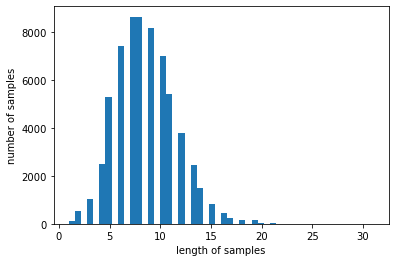

In [30]:
print('최대 길이 :',max(len(l) for l in train))
print('평균 길이 :',sum(map(len, train))/len(train))
plt.hist([len(s) for s in train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
# max_len이하인 데이터의 비율 확인 함수
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 30
below_threshold_len(max_len, train)
below_threshold_len(max_len, test)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.99845150900447
전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [33]:
# 전체 샘플 길이 max_len으로 맞춤
train = pad_sequences(train, maxlen = max_len)
test = pad_sequences(test, maxlen = max_len)

In [34]:
embedding_dim = 100
hidden_units = 128

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-09 23:53:15.106507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 23:53:15.106918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

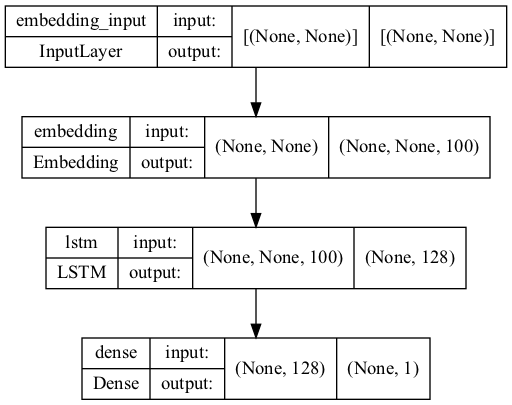

In [37]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1800400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,917,777
Trainable params: 1,917,777
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train, label_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/50


2022-06-09 23:53:18.960671: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 23:53:20.484646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-09 23:53:20.698435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-09 23:53:20.859383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


808/808 [==============================] - ETA: 0s - loss: 0.6653 - acc: 0.6031

2022-06-09 23:53:41.042454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-09 23:53:41.110652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.51943, saving model to best_model.h5
808/808 [==============================] - 25s 28ms/step - loss: 0.6653 - acc: 0.6031 - val_loss: 0.7181 - val_acc: 0.5194
Epoch 2/50
808/808 [==============================] - ETA: 0s - loss: 0.6071 - acc: 0.6719
Epoch 2: val_acc did not improve from 0.51943
808/808 [==============================] - 36s 44ms/step - loss: 0.6071 - acc: 0.6719 - val_loss: 0.7670 - val_acc: 0.5146
Epoch 3/50
807/808 [============================>.] - ETA: 0s - loss: 0.5626 - acc: 0.7102
Epoch 3: val_acc did not improve from 0.51943
808/808 [==============================] - 30s 37ms/step - loss: 0.5626 - acc: 0.7102 - val_loss: 0.7655 - val_acc: 0.5145
Epoch 4/50
808/808 [==============================] - ETA: 0s - loss: 0.5222 - acc: 0.7410
Epoch 4: val_acc did not improve from 0.51943
808/808 [==============================] - 24s 29ms/step - loss: 0.5222 - acc: 0.7410 - val_loss: 0.8083 - val_acc: 0.5111
Epoch 5/50
807/808

In [40]:
model.save('best_model_with_kospi_up_down.h5')

In [41]:
print("정확도 : %.4f" % (model.evaluate(test, label_test)[1]))

1252/1252 [==============================] - 12s 10ms/step - loss: 0.8749 - acc: 0.4910
정확도 : 0.4910


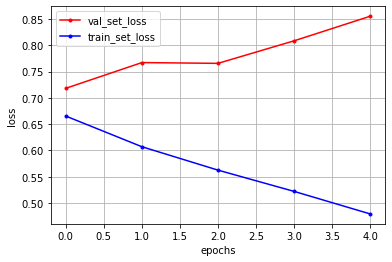

In [42]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
# plt.savefig('LSTM_loss_1112.png')

In [43]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = han.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정적입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정적입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict("정말 재미있어요")

57.24% 확률로 긍정적입니다.



2022-06-09 23:55:47.730530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-09 23:55:47.786176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [45]:
okt = Hannanum()

In [46]:
from konlpy.tag import Mecab

'-d /usr/local/lib/mecab/dic/mecab-ko-dic'

In [47]:
mcb = Mecab()
text = "안녕하세요 제 이름은 이선우 입니다."


In [48]:
mcb.pos(text, flatten=False, join=True)

[['안녕/NNG', '하/XSV', '세요/EP+EF'],
 ['제/NP'],
 ['이름/NNG', '은/JX'],
 ['이선우/NNP'],
 ['입니다/VCP+EF', './SF']]

In [49]:
mcb.morphs(text)

['안녕', '하', '세요', '제', '이름', '은', '이선우', '입니다', '.']

In [50]:
import requests
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import re
import datetime 
from konlpy.tag import Hannanum
from config import * # config안의 정보 가져오기

In [51]:
def get_today_stock_news_data_list (ticker_name):

    #start_time = datetime.datetime.today().strftime("%Y-%m-%dT00:00:00")
    #end_time = datetime.datetime.today().strftime("%Y-%m-%dT23:59:59") 이건 오늘 날짜로 따질때 이야기

    start_time = "2022-04-05T00:00:00"
    end_time = "2022-04-05T23:59:59"


    headers = {
    'Content-Type': 'application/json'
    }

    url = f"{ELASTIC_SEARCH_URL}/news/_count"

    query=f'''{{
    "query": {{
      "bool": {{
        "must": [
          {{
            "match": {{
              "body": "{ticker_name}"
            }}
          }},
          {{
            "range": {{
              "created_at": {{
               "gte": "{start_time}",
               "lte": "{end_time}"
              }}
            }}
          }}
        ]
      }}
    }}
    }}'''

    count = int(requests.get(url, data=query.encode('utf-8'), headers=headers, auth = ELASTIC_SEARCH_AUTH).json()['count'])

    if count != 0:

      url = f"{ELASTIC_SEARCH_URL}/news/_search"

      query=f'''{{
      "size": {count},
      "query": {{
        "bool": {{
          "must": [
            {{
              "match": {{
                "body": "{ticker_name}"
              }}
            }},
            {{
              "range": {{
                "created_at": {{
                "gte": "{start_time}",
                "lte": "{end_time}"
                }}
              }}
            }}
          ]
        }}
      }}
      }}'''  

      resp = requests.get(url, data=query.encode('utf-8'), headers=headers, auth = ELASTIC_SEARCH_AUTH).json()

      resp = resp['hits']['hits']
    
    else:

      resp = []


    return resp

def clean_doc (doc):
    
    doc = re.sub(r'[^\wㄱ-ㅎ가-힣]', ' ', doc)
    doc = re.sub('  ', ' ', doc)
    doc = re.sub('  ', ' ', doc)

    return doc

def title_extract(doc):
    
    return doc['_source']['title']
    
def body_extract (doc):

    return doc['_source']['body']

In [52]:
stock1_doc_list = get_today_stock_news_data_list("삼성전자")
title_list = [title_extract(x) for x in stock1_doc_list]

title_list[0:5]
body_list = []

for i in stock1_doc_list[0:10]:
    a = body_extract(i)
    a = clean_doc(a)
    body_list.append(a)

In [53]:
for i in body_list[0:10]:
    print("\n")
    sentiment_predict(i)
    print(i)
    
for i in title_list[0:10]:
    print("\n")
    sentiment_predict(i)
    print("\n")
    print(i)



57.88% 확률로 부정적입니다.

 반도체 수퍼사이클 장기 상승장 이라고 해서 샀는데 계속 물타다가 대주주 되겠어요 이번에 실적 발표를 보고 추매와 손절 중에 선택하려고요 50대 투자자 이모씨 오는 7일 삼성전자의 1분기 1 3월 실적 발표일을 앞두고 500만 삼성전자 소액 주주들이 초긴장 모드다 삼성전자 주가가 5일 6만9200원까지 주저앉은 가운데 1분기 실적 발표를 보면서 향후 투자의 방향을 결정하려는 것이다 이날 한국거래소에 따르면 올해 개인 투자자들은 삼성전자 주식을 6조5000억원 어치 사모았다 삼성전자 우선주까지 합하면 7조원이 넘는다 같은 기간 연기금 등 기관은 삼성전자 주식을 5조원 넘게 팔아 치웠고 외국인도 1조원 넘게 순매도했다 개인들은 삼성전자 주가가 6만원대로 떨어진 3월에만 3조8000억원 어치 순매수했다 나머지 2 10위 종목들의 순매수 금액을 다 합해도 삼성전자 한 종목에 미치지 못한다 그래픽 이연주 조선디자인랩 기자 개인 투자자들이 주목하고 있는 삼성전자의 1분기 실적 전망은 어떨까 이달 초 금융정보업체 에프앤가이드가 집계한 자료에 따르면 삼성전자 1분기 실적에 대한 증권사 전망치 컨센서스 는 매출액 75조823억원 영업이익은 13조283억원이다 증권가 예상이 맞다면 삼성전자는 1분기 기준으로 매출 70조원 시대를 처음 열게 된다 1분기 호실적 발표가 예상되고 있지만 주가 흐름은 영 신통치 않다 지난 4일 삼성전자 종가는 6만9300원 올해 들어서만 12 하락했다 작년 초만 해도 반도체 수퍼사이클 전망이 나오면서 주가는 9만원을 돌파해 10만원 턱밑까지 올랐지만 1년여 만에 6만원대로 밀려 버렸다 편득현 NH투자증권 WM마스터즈 전문위원은 삼성전자는 한국 증시에 대한 비중을 낮추는 연기금과 외국인들의 집중 타깃이 되고 있다 면서 올해 실적 개선폭이 전년 대비 크지 않다는 이유로 매도세가 이어지는 모습 이라고 말했다 편 위원은 이어 하지만 환율 효과로 실적이 예상보다 더 좋게 나올 수 있고 두 매매 주체가 연일 큰 규모로 매도

In [54]:
ret

NameError: name 'ret' is not defined

In [ ]:
!pip install eunjeon

  Using cached eunjeon-0.4.0.tar.gz (34.7 MB)
  Created wheel for eunjeon: filename=eunjeon-0.4.0-cp38-cp38-macosx_11_0_arm64.whl size=34077890 sha256=59a34a966b11252002d060f27a87a6815908d3f7613ecbb6fece3252237a65cb
  Stored in directory: /Users/Sun/Library/Caches/pip/wheels/4b/1d/e9/bfa4c18245fc292aaa650fe6dd982a4feddfaab49f3b8f9f25
Successfully built eunjeon


In [ ]:
from eunjeon import MeCab

m = MeCab()

m.pos("안녕하세요 제 이름은 이선우 입니다.")

ImportError: cannot import name 'MeCab' from 'eunjeon' (/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/eunjeon/__init__.py)